In [1]:
__imp

Libraries have been loaded


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display

from sklearn import metrics

In [4]:
set_plot_sizes(12,14,16)

### Load Processed Data

In [65]:
PATH = '../data/interim/dataset1/application_train.pkl'

df_raw = pd.read_pickle(PATH)
df_trn, y_trn, nas = proc_df(df_raw, 'TARGET')

In [6]:
def split_vals(X, y, test_size=.3):
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, stratify=y, test_size=test_size, random_state=SEED)
    
    return X_trn, X_val, y_trn, y_val

In [7]:
X_tr, X_val, y_tr, y_val = split_vals(df_trn, y_trn)
print(X_tr.shape, ' ', X_val.shape)

(215257, 182)   (92254, 182)


In [23]:
def print_score(m, X_tr, y_tr, X_val, y_val):
    res = [metrics.log_loss(y_tr, m.predict_proba(X_tr)[:, 1]), 
           metrics.log_loss(y_val, m.predict_proba(X_val)[:, 1]),
           metrics.roc_auc_score(y_tr, m.predict_proba(X_tr)[:, 1]), 
           metrics.roc_auc_score(y_val, m.predict_proba(X_val)[:, 1])]
    
    print(res)

In [9]:
# take a sample
set_rf_samples(50000)

In [11]:
%%time

m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, random_state=SEED, n_jobs=-1)
m.fit(X_tr, y_tr)
print_score(m, X_tr, y_tr, X_val, y_val)

[0.18403148695067784, 0.3047896801414269, 0.9456644417416082, 0.7031426878235745]
CPU times: user 2min 37s, sys: 1.76 s, total: 2min 39s
Wall time: 50.1 s


### Feature Importance

In [12]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
37,EXT_SOURCE_2,0.082162
38,EXT_SOURCE_3,0.070986
24,DAYS_ID_PUBLISH,0.044870
26,DAYS_REGISTRATION,0.044036
22,DAYS_BIRTH,0.043378
111,SK_ID_CURR,0.042381
25,DAYS_LAST_PHONE_CHANGE,0.038397
23,DAYS_EMPLOYED,0.037849
0,AMT_ANNUITY,0.037843
104,REGION_POPULATION_RELATIVE,0.031511


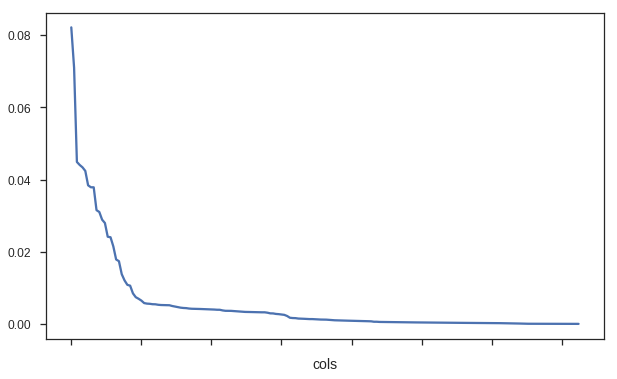

In [13]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [14]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

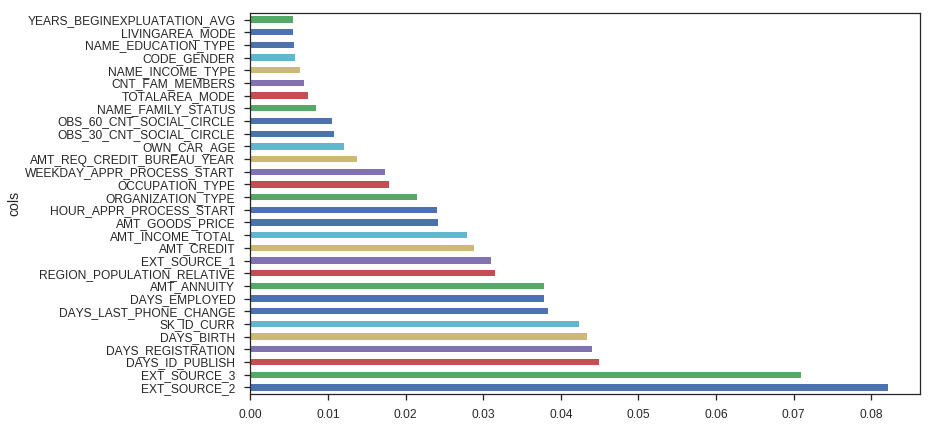

In [15]:
plot_fi(fi[:30]);

In [16]:
to_keep = fi[fi.imp>0.0003].cols; len(to_keep)

140

In [17]:
df_keep = df_trn[to_keep].copy()
X_tr, X_val, y_tr, y_val = split_vals(df_keep, y_trn)

In [18]:
%%time

m = RandomForestClassifier(n_estimators=50, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m.fit(X_tr, y_tr)
print_score(m, X_tr, y_tr, X_val, y_val)

[0.1834296858808568, 0.2898750371109395, 0.9497122806403456, 0.7081701563102523]
CPU times: user 2min 54s, sys: 1.38 s, total: 2min 55s
Wall time: 52.7 s


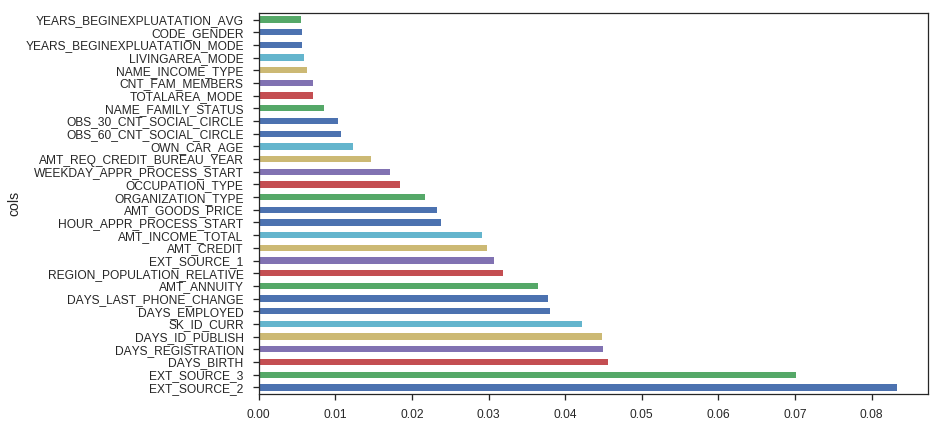

In [19]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:30]);

In [91]:
def get_oob(df_keep, y_trn, m=None):
    X_tr, X_val, y_tr, y_val = split_vals(df_keep, y_trn)
    
    if m is None:
        m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
    
    m.fit(X_tr, y_tr)
    print_score(m, X_tr, y_tr, X_val, y_val)
    
    return m

In [25]:
df_keep.loc[:, 'ratio_credit_annuity'] = df_keep.AMT_CREDIT / df_keep.AMT_ANNUITY
m = get_oob(df_keep, y_trn)

[0.18364297823003745, 0.2994463551420876, 0.9454479834464232, 0.7055082332601511]


In [56]:
%%time

m = RandomForestClassifier(n_estimators=10, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m.fit(X_tr, y_tr)
print_score(m)

[0.1585635992158682, 0.6655443636539808, 0.9630816101967034, 0.6637534582309336]
CPU times: user 1min 6s, sys: 1.33 s, total: 1min 7s
Wall time: 25.8 s


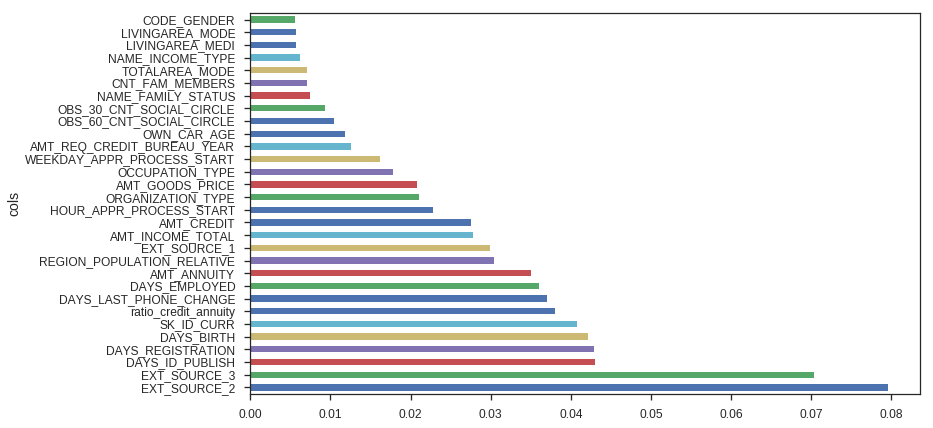

In [26]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:30]);

### EXT_SOURCE_2 ( Normalized Score from external data source )

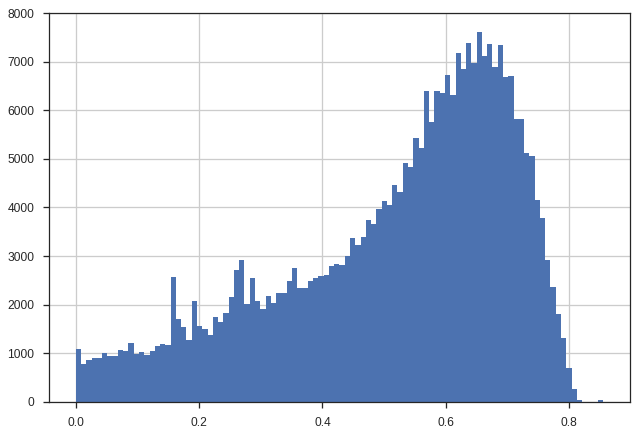

In [63]:
df_trn.EXT_SOURCE_2.hist(bins=100);

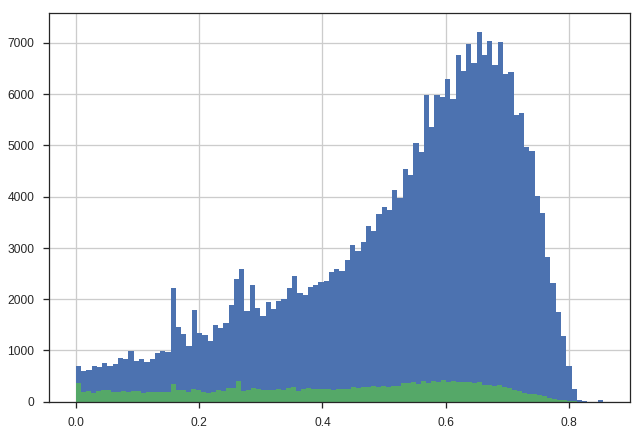

In [68]:
df_trn[ y_trn == 0].EXT_SOURCE_2.hist(bins=100)
df_trn[ y_trn == 1].EXT_SOURCE_2.hist(bins=100);

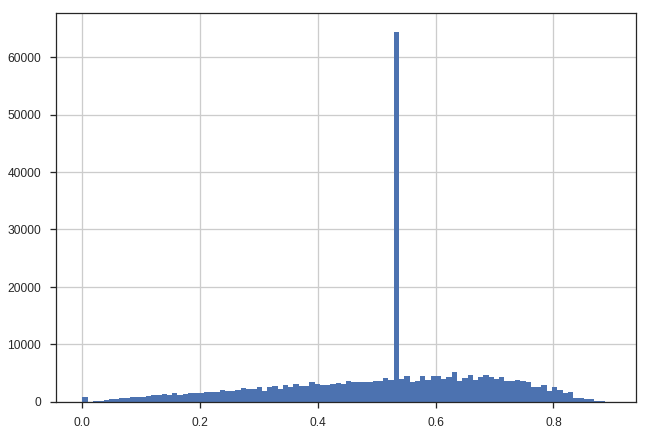

In [70]:
df_trn.EXT_SOURCE_3.hist(bins=100);

** Spike is due to missing value imputation. **

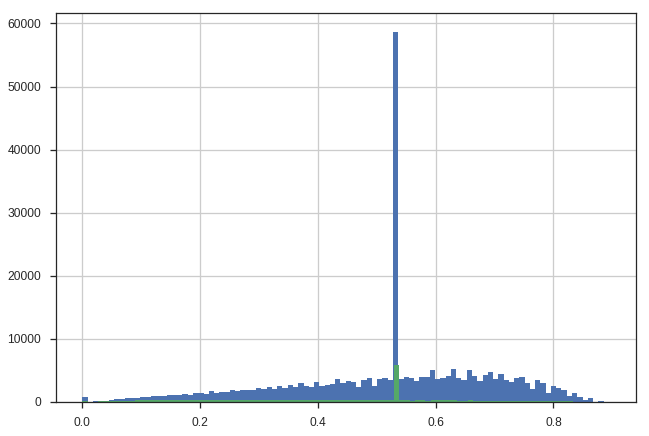

In [74]:
df_trn[ y_trn == 0].EXT_SOURCE_3.hist(bins=100)
df_trn[ y_trn == 1].EXT_SOURCE_3.hist(bins=100);

### Interaction between EXT_SOURCE_2 and EXT_SOURCE_3

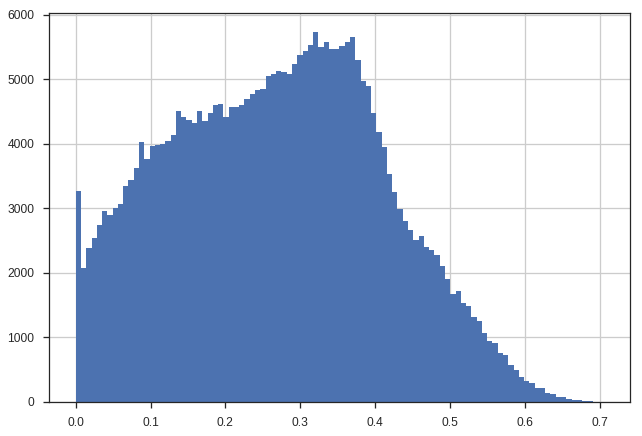

In [77]:
(df_trn.EXT_SOURCE_2 * df_trn.EXT_SOURCE_3).hist(bins=100);

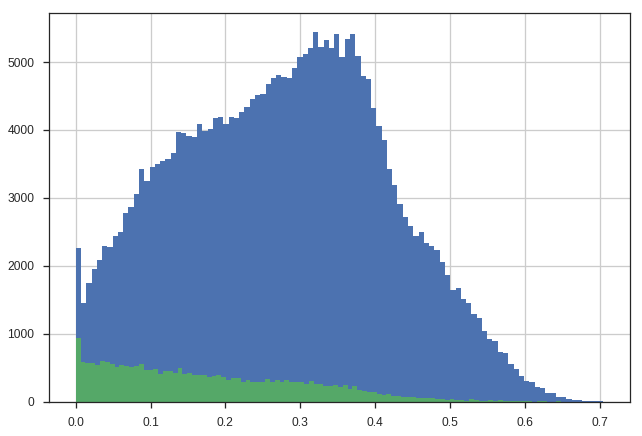

In [78]:
(df_trn.EXT_SOURCE_2 * df_trn.EXT_SOURCE_3)[ y_trn==0 ].hist(bins=100)
(df_trn.EXT_SOURCE_2 * df_trn.EXT_SOURCE_3)[ y_trn==1 ].hist(bins=100);

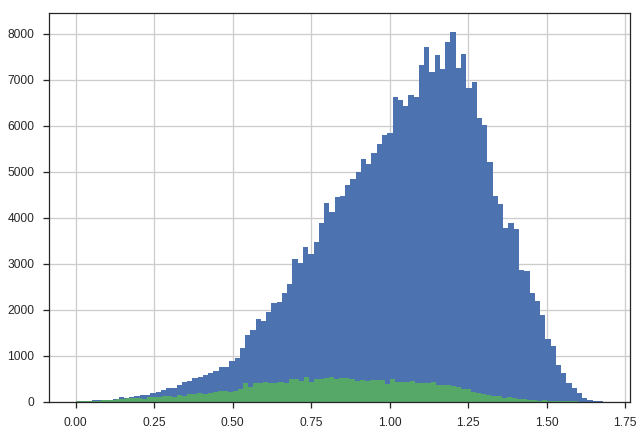

In [79]:
(df_trn.EXT_SOURCE_2 + df_trn.EXT_SOURCE_3)[ y_trn==0 ].hist(bins=100)
(df_trn.EXT_SOURCE_2 + df_trn.EXT_SOURCE_3)[ y_trn==1 ].hist(bins=100);

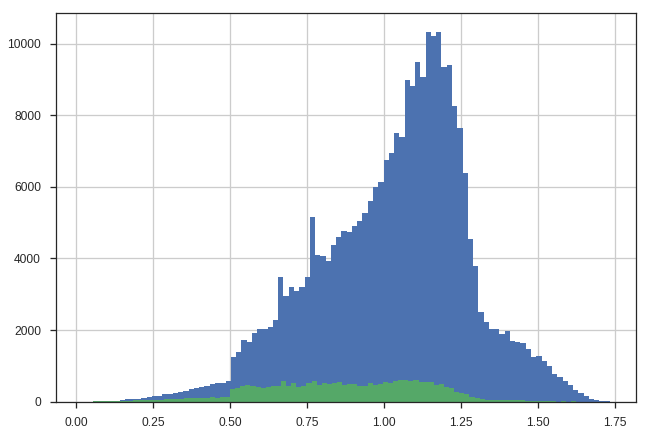

In [106]:
(df_trn.EXT_SOURCE_1 + df_trn.EXT_SOURCE_2)[ y_trn==0 ].hist(bins=100)
(df_trn.EXT_SOURCE_1 + df_trn.EXT_SOURCE_2)[ y_trn==1 ].hist(bins=100);

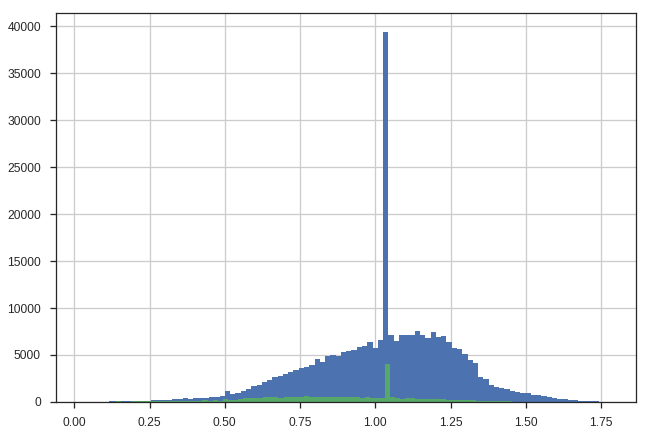

In [108]:
(df_trn.EXT_SOURCE_1 + df_trn.EXT_SOURCE_3)[ y_trn==0 ].hist(bins=100)
(df_trn.EXT_SOURCE_1 + df_trn.EXT_SOURCE_3)[ y_trn==1 ].hist(bins=100);

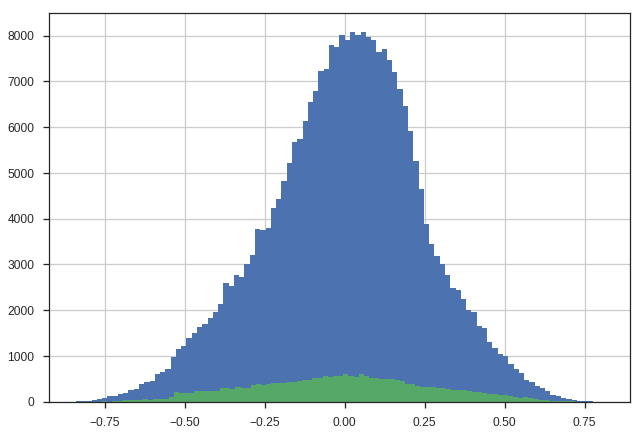

In [80]:
(df_trn.EXT_SOURCE_2 - df_trn.EXT_SOURCE_3)[ y_trn==0 ].hist(bins=100)
(df_trn.EXT_SOURCE_2 - df_trn.EXT_SOURCE_3)[ y_trn==1 ].hist(bins=100);

In [27]:
df_keep.loc[:, 'mult_ext_source_2_3']   = df_keep.EXT_SOURCE_2 * df_keep.EXT_SOURCE_3
df_keep.loc[:, 'add_ext_source_2_3']    = df_keep.EXT_SOURCE_2 + df_keep.EXT_SOURCE_3
df_keep.loc[:, 'diff_days_publish_reg'] = df_keep.DAYS_ID_PUBLISH - df_keep.DAYS_REGISTRATION

m = get_oob(df_keep, y_trn)

[0.18276634875255632, 0.30539034976865015, 0.9473959581857149, 0.7061045570033311]


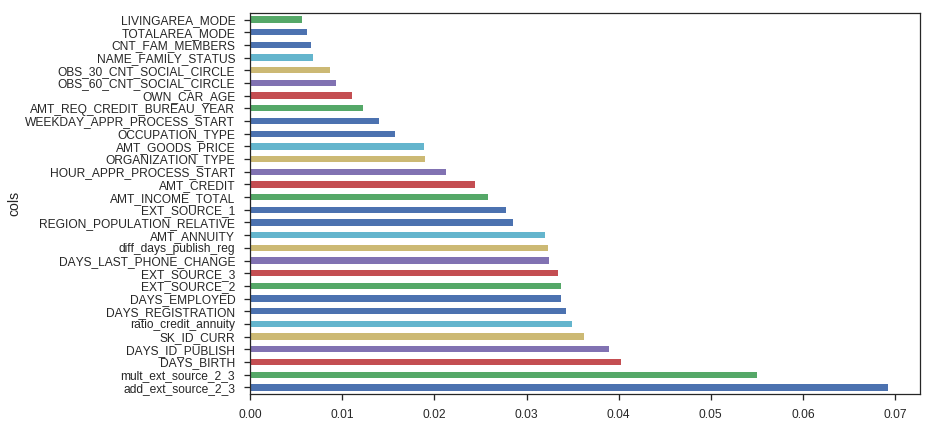

In [28]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:30]);

### DAYS_ID_Publish: How many days before did client the identity document ?

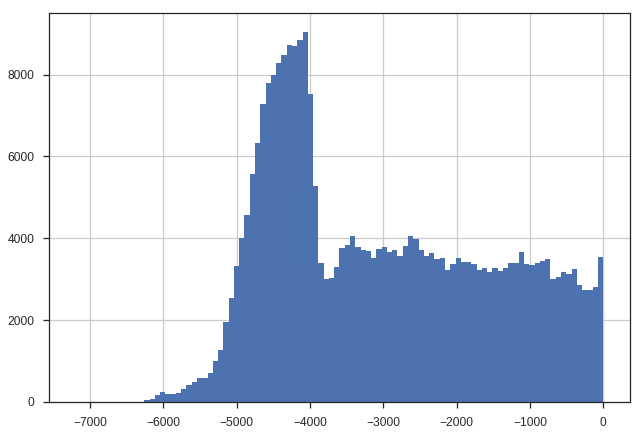

In [135]:
df_trn.DAYS_ID_PUBLISH.hist(bins=100);

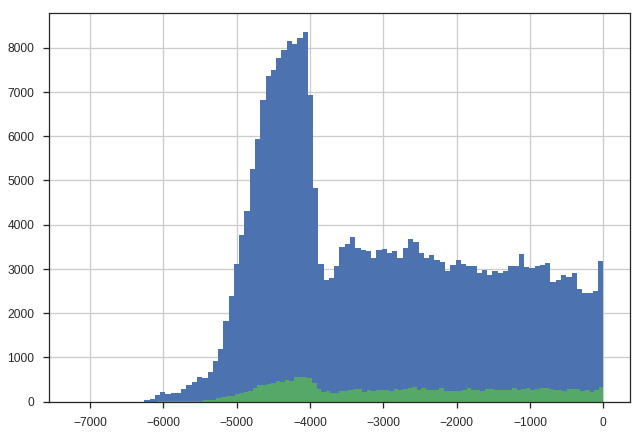

In [136]:
df_trn[ y_trn==0 ].DAYS_ID_PUBLISH.hist(bins=100)
df_trn[ y_trn==1 ].DAYS_ID_PUBLISH.hist(bins=100);

### Days Registration: How many days before the application did client change his registration ?

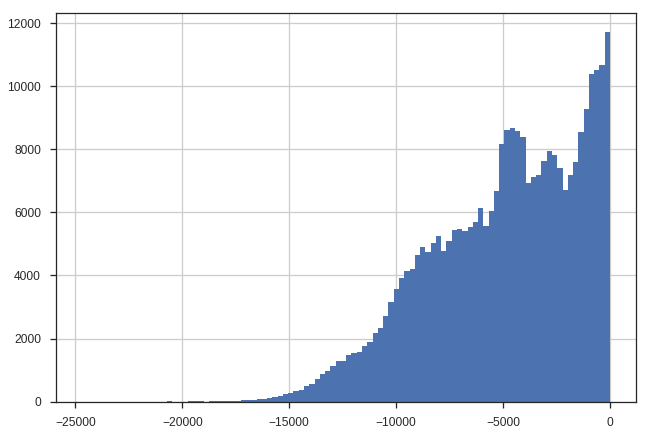

In [137]:
df_trn.DAYS_REGISTRATION.hist(bins=100);

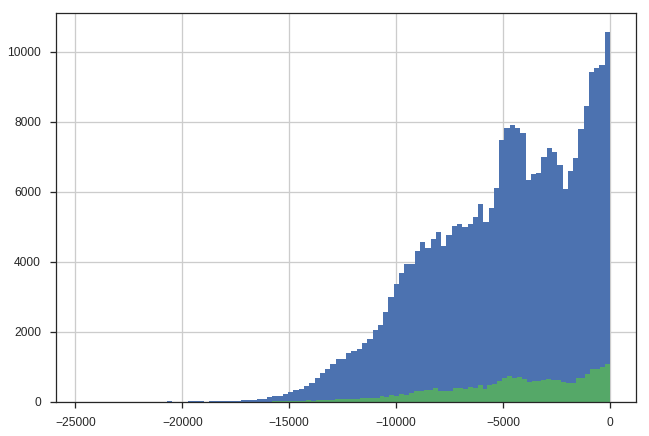

In [138]:
df_trn[ y_trn==0 ].DAYS_REGISTRATION.hist(bins=100)
df_trn[ y_trn==1 ].DAYS_REGISTRATION.hist(bins=100);

#### DAYS_ID_PUBLISH - DAYS_REGISTRATION

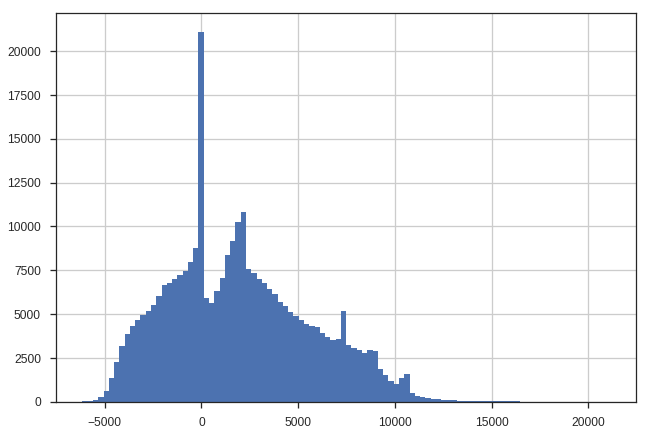

In [139]:
(df_trn.DAYS_ID_PUBLISH - df_trn.DAYS_REGISTRATION).hist(bins=100);

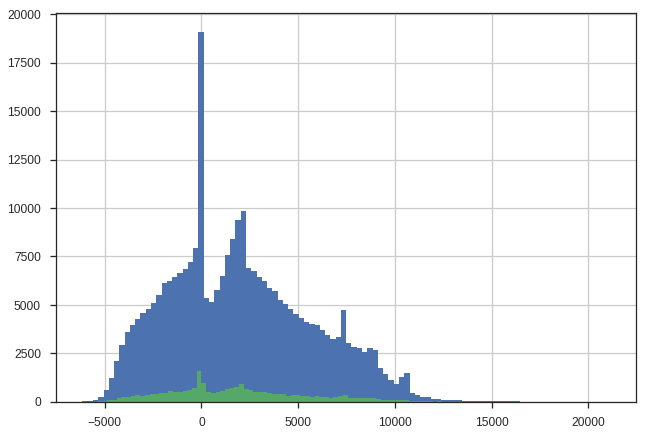

In [141]:
(df_trn.DAYS_ID_PUBLISH - df_trn.DAYS_REGISTRATION)[ y_trn==0 ].hist(bins=100)
(df_trn.DAYS_ID_PUBLISH - df_trn.DAYS_REGISTRATION)[ y_trn==1 ].hist(bins=100);

### DAYS BIRTH ( AGE )

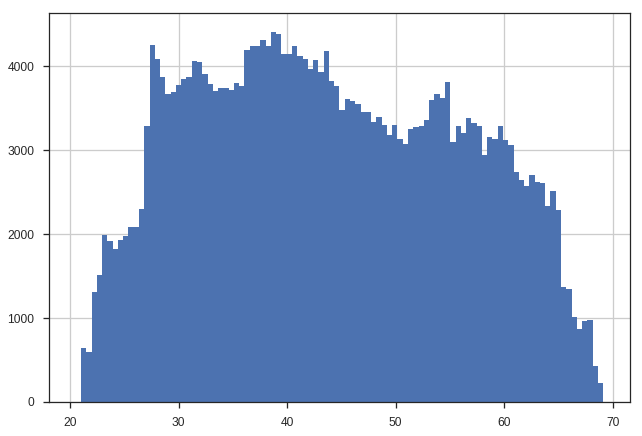

In [33]:
(-df_trn.DAYS_BIRTH / 365).hist(bins=100);

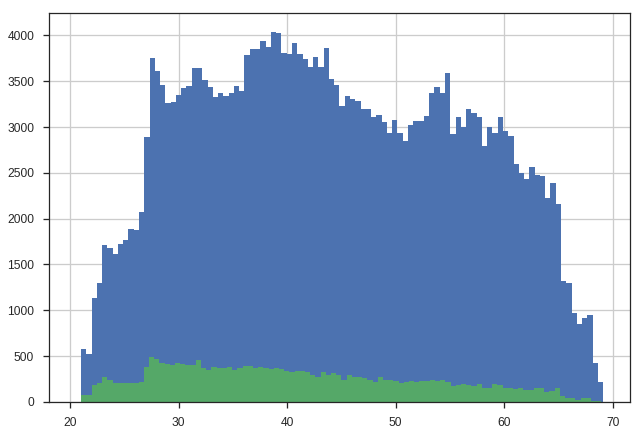

In [34]:
(-df_trn.DAYS_BIRTH / 365)[ y_trn==0 ].hist(bins=100);
(-df_trn.DAYS_BIRTH / 365)[ y_trn==1 ].hist(bins=100);

#### Relationship between AGE and days befor id was changed

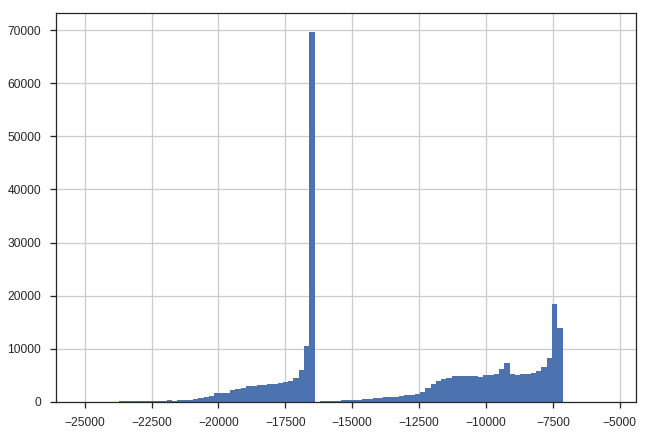

In [41]:
((df_trn.DAYS_BIRTH - df_trn.DAYS_ID_PUBLISH)).hist(bins=100);

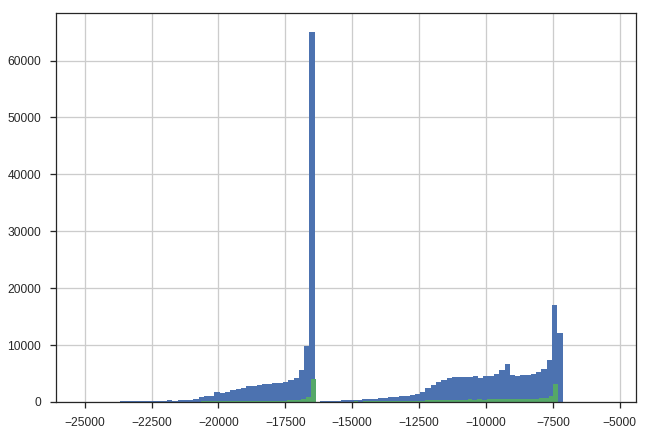

In [47]:
((df_trn.DAYS_BIRTH - df_trn.DAYS_ID_PUBLISH))[ y_trn==0 ].hist(bins=100)
((df_trn.DAYS_BIRTH - df_trn.DAYS_ID_PUBLISH))[ y_trn==1 ].hist(bins=100);

In [51]:
df_keep.loc[:, 'age_cat']   = (-df_keep.DAYS_BIRTH / 365).astype(np.int)

m = get_oob(df_keep, y_trn)

[0.18262981979414028, 0.3098574650746025, 0.9475894788318355, 0.7053466106683421]


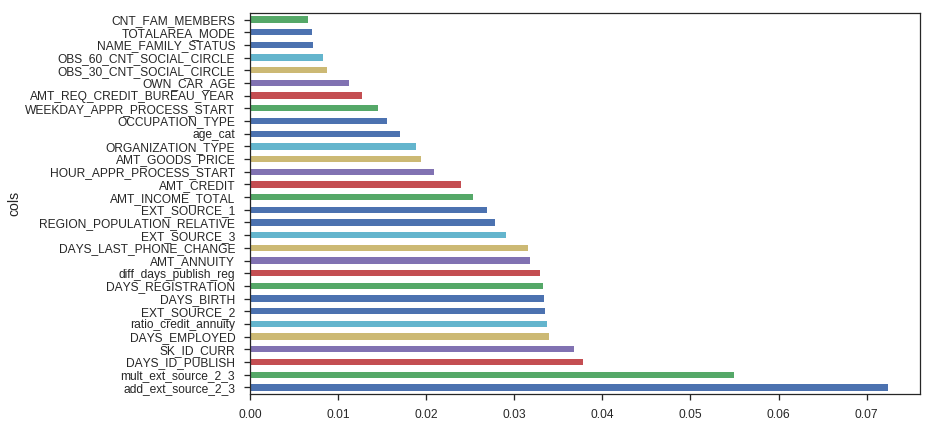

In [52]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:30]);

### Relationship between Age and External scores

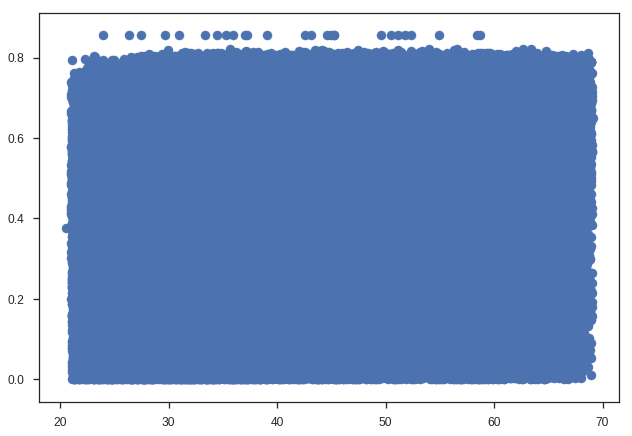

In [56]:
plt.scatter(-df_trn.DAYS_BIRTH / 365, df_trn.EXT_SOURCE_2);

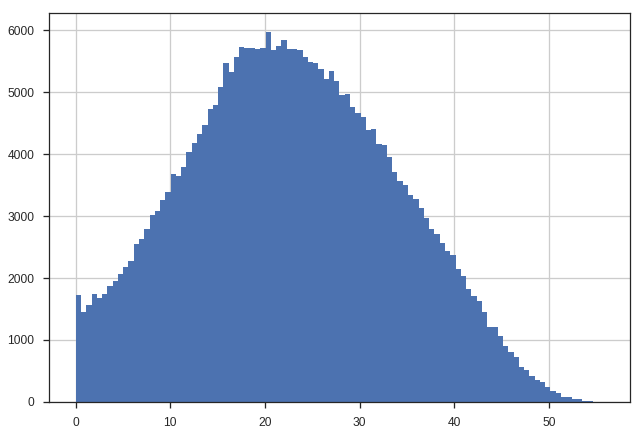

In [60]:
((-df_trn.DAYS_BIRTH / 365) * df_trn.EXT_SOURCE_2).hist(bins=100);

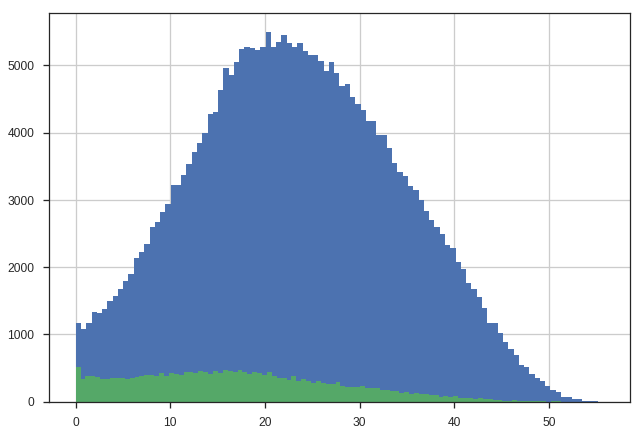

In [61]:
((-df_trn.DAYS_BIRTH / 365) * df_trn.EXT_SOURCE_2)[ y_trn==0 ].hist(bins=100)
((-df_trn.DAYS_BIRTH / 365) * df_trn.EXT_SOURCE_2)[ y_trn==1 ].hist(bins=100);

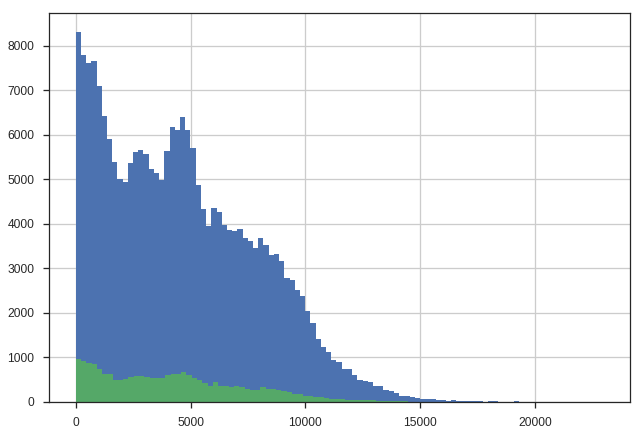

In [90]:
mask = df_trn.DAYS_EMPLOYED != 365243
((-df_trn.loc[mask, 'DAYS_EMPLOYED'] / 365) - df_trn.loc[mask, 'DAYS_REGISTRATION'])[ y_trn[mask]==0 ].hist(bins=100)
((-df_trn.loc[mask, 'DAYS_EMPLOYED'] / 365) - df_trn.loc[mask, 'DAYS_REGISTRATION'])[ y_trn[mask]==1 ].hist(bins=100);

In [109]:
df_keep = df_trn.copy()

df_keep.loc[:, 'annuity_credit'] = df_keep.AMT_CREDIT / df_keep.AMT_ANNUITY
df_keep.loc[:, 'add_ext_2_3']    = df_keep.EXT_SOURCE_2 + df_keep.EXT_SOURCE_3
df_keep.loc[:, 'mult_ext_2_3']   = df_keep.EXT_SOURCE_2 * df_keep.EXT_SOURCE_3
df_keep.loc[:, 'diff_ext_2_3']   = df_keep.EXT_SOURCE_2 - df_keep.EXT_SOURCE_3
df_keep.loc[:, 'add_ext_1_2']    = df_keep.EXT_SOURCE_1 + df_keep.EXT_SOURCE_2
df_keep.loc[:, 'ext_2_age']      = df_keep.EXT_SOURCE_2 * (-df_keep.DAYS_BIRTH / 365)
df_keep.loc[:, 'ext_3_age']      = df_keep.EXT_SOURCE_3 * (-df_keep.DAYS_BIRTH / 365)

m = get_oob(df_keep, y_trn) # baseline score

[0.18288991632324889, 0.2999894517318479, 0.9468288421345213, 0.7055682212195279]


In [110]:
m = get_oob(df_keep, y_trn, m=RandomForestClassifier(n_estimators=50, 
                                                     min_samples_leaf=100, 
                                                     max_depth=7,
                                                     max_features=.8,
                                                     random_state=SEED, 
                                                     n_jobs=-1))

[0.24977048366521348, 0.25255961063486804, 0.7476968875780459, 0.7363870656279944]


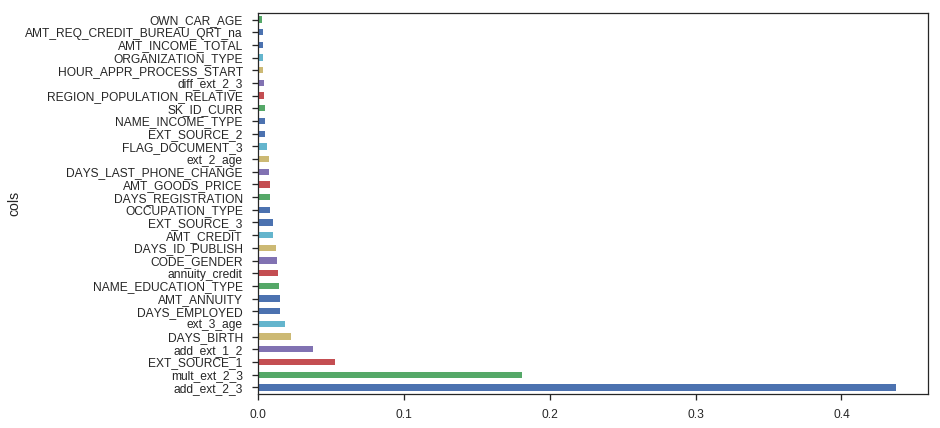

In [111]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:30]);

In [134]:
to_keep = fi[fi.imp>0.01].cols; len(to_keep)

14

In [138]:
df_keep_sub = df_keep[to_keep].copy()
m = get_oob(df_keep_sub, y_trn, m=RandomForestClassifier(n_estimators=100, 
                                                     min_samples_leaf=100, 
                                                     max_depth=12,
                                                     random_state=SEED, 
                                                     n_jobs=-1))

[0.24655780454193207, 0.25129027673459037, 0.7618892143700262, 0.7417697890779621]


In [143]:
to_keep

183            add_ext_2_3
184           mult_ext_2_3
36            EXT_SOURCE_1
186            add_ext_1_2
22              DAYS_BIRTH
188              ext_3_age
23           DAYS_EMPLOYED
0              AMT_ANNUITY
88     NAME_EDUCATION_TYPE
182         annuity_credit
18             CODE_GENDER
24         DAYS_ID_PUBLISH
1               AMT_CREDIT
38            EXT_SOURCE_3
Name: cols, dtype: object

## Source of overfitting

In [113]:
X_tr, X_val, y_tr, y_val = split_vals(df_keep, y_trn)

In [117]:
def get_preds(t): return t.predict_proba(X_val)[:, 1]
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 116 ms, sys: 196 ms, total: 312 ms
Wall time: 23.1 s


(0.23275846969669547, 0.08672369489567952)

In [118]:
x   = X_val.copy()
x.loc[:, 'TARGET'] = y_val.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred']     = np.mean(preds, axis=0)

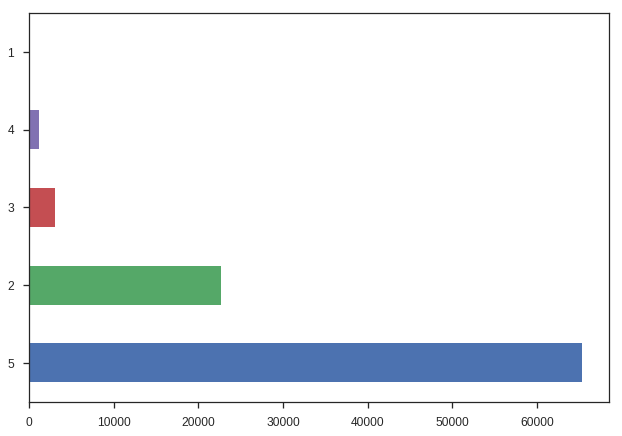

In [119]:
x.NAME_EDUCATION_TYPE.value_counts().plot.barh();

In [120]:
flds = ['NAME_EDUCATION_TYPE', 'TARGET', 'pred', 'pred_std']
summ = x[flds].groupby('NAME_EDUCATION_TYPE', as_index=False).mean()
summ

,NAME_EDUCATION_TYPE,TARGET,pred,pred_std
0,1,0.000000,0.060643,0.029042
1,2,0.053009,0.065481,0.033151
2,3,0.090393,0.089850,0.041142
3,4,0.103943,0.091836,0.039604
4,5,0.089539,0.084567,0.036265


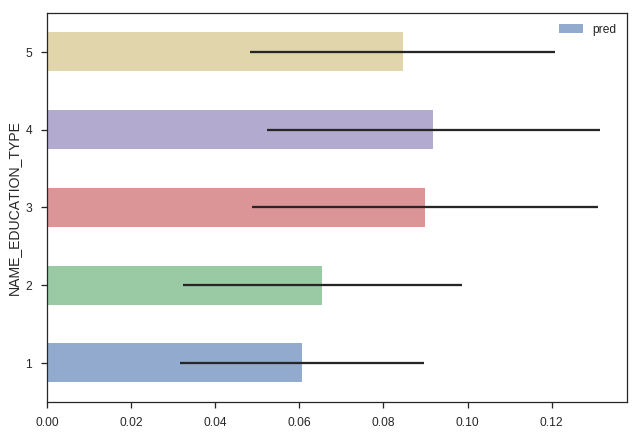

In [121]:
summ = summ[~pd.isnull(summ.TARGET)]
summ.plot('NAME_EDUCATION_TYPE', 'pred', 'barh', xerr='pred_std', alpha=0.6);

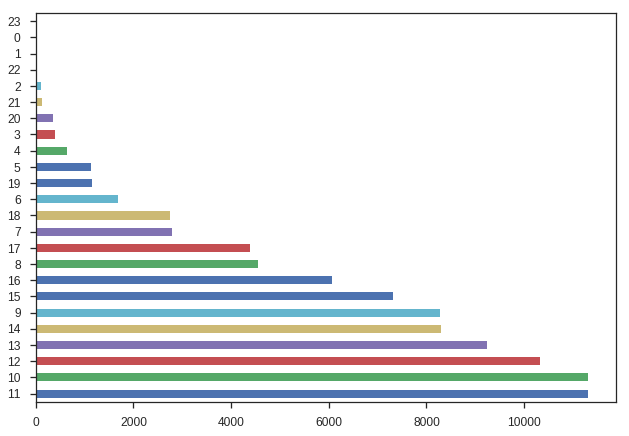

In [122]:
x.HOUR_APPR_PROCESS_START.value_counts().plot.barh();

In [128]:
flds = ['HOUR_APPR_PROCESS_START', 'TARGET', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0], as_index=False).mean()
summ

,HOUR_APPR_PROCESS_START,TARGET,pred,pred_std
0,0,0.117676,0.060826,0.029900
1,1,0.045441,0.090757,0.037290
2,2,0.103088,0.068596,0.031744
3,3,0.090210,0.082191,0.036436
4,4,0.077759,0.087155,0.039123
5,5,0.100342,0.096910,0.042451
6,6,0.118408,0.101406,0.044007
7,7,0.096741,0.095136,0.041150
8,8,0.089172,0.090869,0.039447
9,9,0.080200,0.082071,0.036489


In [124]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

HOUR_APPR_PROCESS_START
0     0.491561
19    0.468141
2     0.462758
18    0.460622
21    0.459877
17    0.456817
15    0.453298
20    0.450902
16    0.449512
4     0.448893
11    0.445305
14    0.444979
10    0.444670
12    0.444641
9     0.444601
13    0.443757
3     0.443308
5     0.438045
8     0.434105
6     0.433969
7     0.432542
22    0.425303
1     0.410878
23    0.372221
dtype: float64

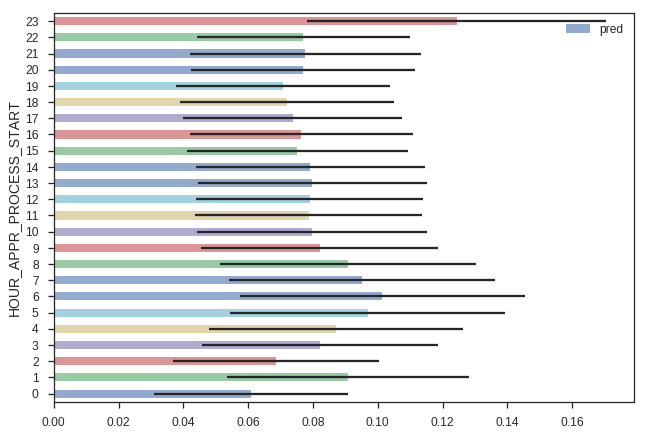

In [129]:
summ = summ[~pd.isnull(summ.TARGET)]
summ.plot('HOUR_APPR_PROCESS_START', 'pred', 'barh', xerr='pred_std', alpha=0.6);